In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from epimodel import EpiModel
from utility import *

import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

N = 1402617695

In [2]:
train_data = pd.read_csv("../data/training.csv")
test_data = pd.read_csv("../data/testing.csv")

In [3]:
print(len(test_data))

111


In [4]:
train_data = process_dataframe(train_data)
test_data = process_dataframe(test_data)

In [5]:
test_data

,Date,Infected,Dead,Recovered,Susceptible,delS,delI,delR,delD,gamma,mu,beta
0,2021-02-08,10847304.0,155158.0,10548521.0,1.381067e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-09,10858371.0,155252.0,10561608.0,1.381042e+09,-24248.0,11067.0,13087.0,94.0,0.001206,0.000009,0.002270
2,2021-02-10,10871294.0,155360.0,10573372.0,1.381018e+09,-24795.0,12923.0,11764.0,108.0,0.001083,0.000010,0.002319
3,2021-02-11,10880603.0,155447.0,10589230.0,1.380992e+09,-25254.0,9309.0,15858.0,87.0,0.001459,0.000008,0.002359
4,2021-02-12,10892746.0,155550.0,10600625.0,1.380969e+09,-23641.0,12143.0,11395.0,103.0,0.001047,0.000009,0.002207
...,...,...,...,...,...,...,...,...,...,...,...,...
106,2021-05-25,27157795.0,311388.0,24350816.0,1.350798e+09,-509033.0,208921.0,295955.0,4157.0,0.010982,0.000154,0.019606
107,2021-05-26,27369093.0,315235.0,24633951.0,1.350299e+09,-498280.0,211298.0,283135.0,3847.0,0.010426,0.000142,0.019051
108,2021-05-27,27555457.0,318895.0,24893410.0,1.349850e+09,-449483.0,186364.0,259459.0,3660.0,0.009480,0.000134,0.017059
109,2021-05-28,27729247.0,322512.0,25178011.0,1.349388e+09,-462008.0,173790.0,284601.0,3617.0,0.010328,0.000131,0.017422


In [6]:
class FFNNet(nn.Module):

    def __init__(self, lookback):
        super(FFNNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(lookback, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [7]:
def prepare_dataloader(param, lookback):

    param_vals = train_data[param].values

    X = torch.Tensor([param_vals[i + 1:i + lookback + 1] for i in range(len(param_vals) - lookback - 1)])
    y = torch.Tensor([param_vals[i + lookback + 1] for i in range(len(param_vals) - lookback - 1)])

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    return loader

In [8]:
def train_param(the_model, param, lookback, epochs):

    dataloader = prepare_dataloader(param, lookback)
    model = the_model(lookback)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.01)

    for epoch in range(epochs):

        for x, y in dataloader:

            pred = model(x).squeeze()
            loss = criterion(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    
    return model

In [9]:
def get_preds(model, param, lookback):

    trained_model = train_param(model, param, lookback, 50)

    param_vals = test_data[param].values
    X = torch.Tensor([param_vals[i + 1:i + lookback + 1] for i in range(len(param_vals) - lookback - 1)])

    trained_model.eval()

    with torch.no_grad():

        preds = trained_model(X)
    
    return preds
    

In [10]:
beta_preds = get_preds(FFNNet, "beta", 5)
gamma_preds = get_preds(FFNNet, "gamma", 5)
mu_preds = get_preds(FFNNet, "mu", 5)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

/var/folders/t3/b0mcdfxs1s78w2fcr925074m0000gq/T/ipykernel_85761/1048995434.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  X = torch.Tensor([param_vals[i + 1:i + lookback + 1] for i in range(len(param_vals) - lookback - 1)])
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50/50, Loss: 0.0103
Epoch 50/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


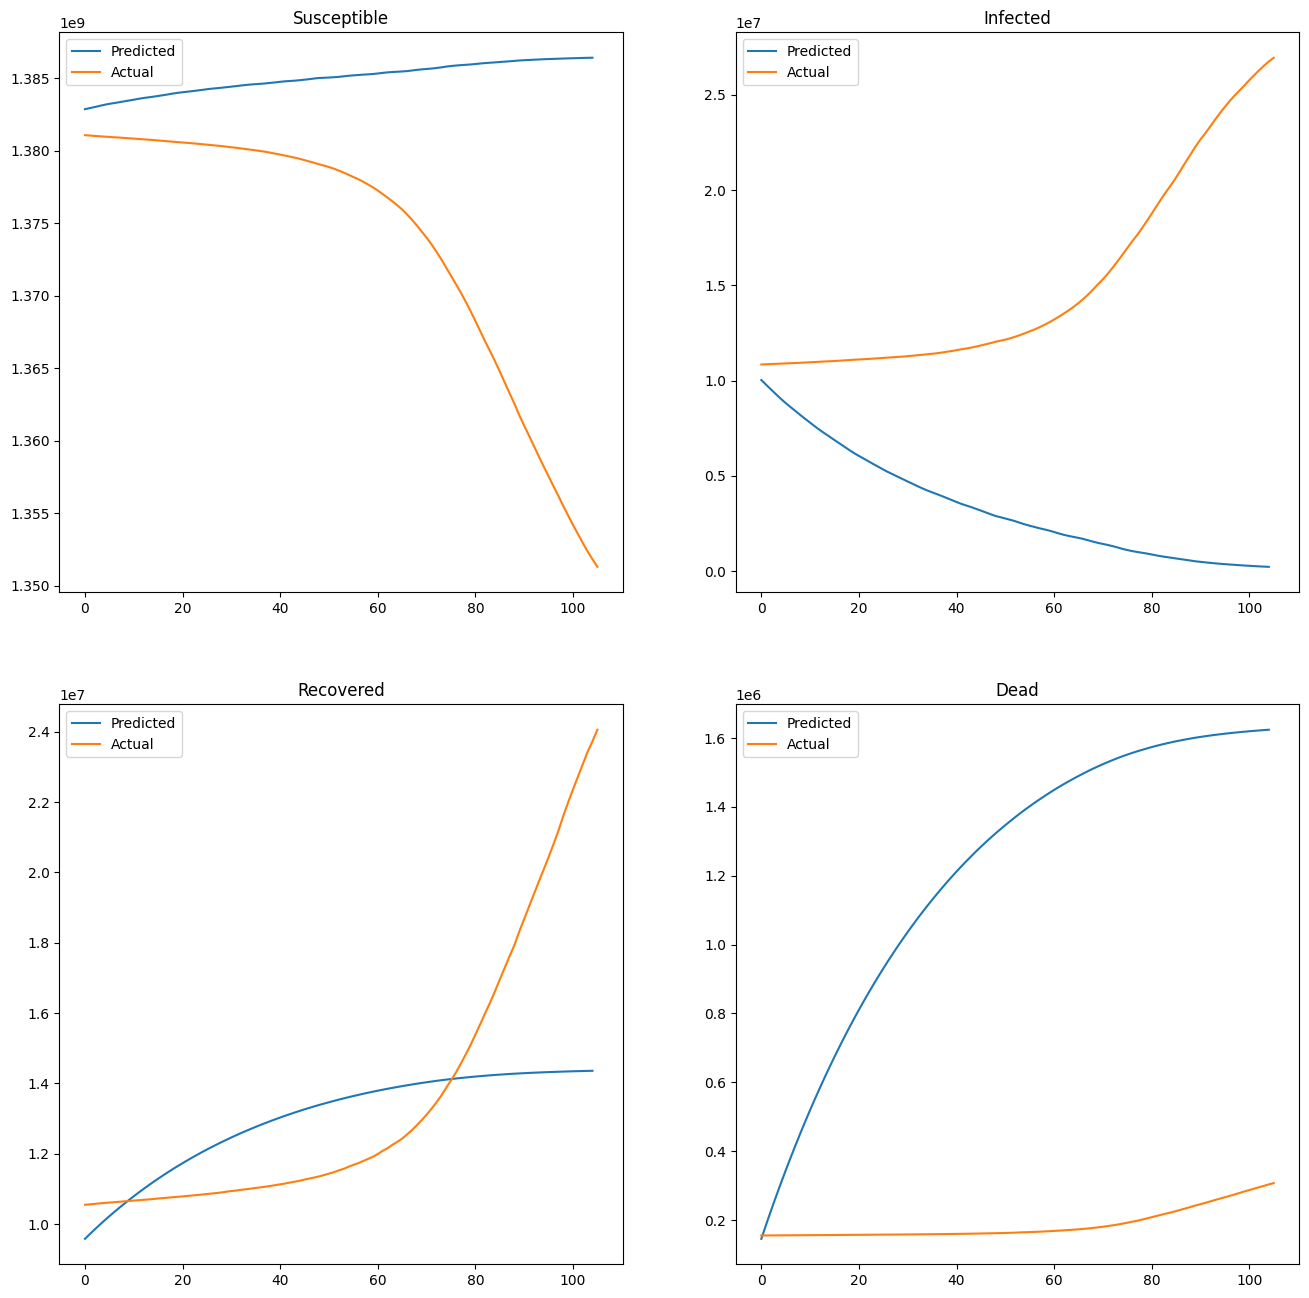

In [11]:
plot_epimodel(FFNNetEpimodel, test_data, 5)

In [12]:
beta_preds = get_preds(FFNNet, "beta", 30)
gamma_preds = get_preds(FFNNet, "gamma", 30)
mu_preds = get_preds(FFNNet, "mu", 30)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

Epoch 50/50, Loss: 0.0001
Epoch 50/50, Loss: 0.0003
Epoch 50/50, Loss: 0.0000


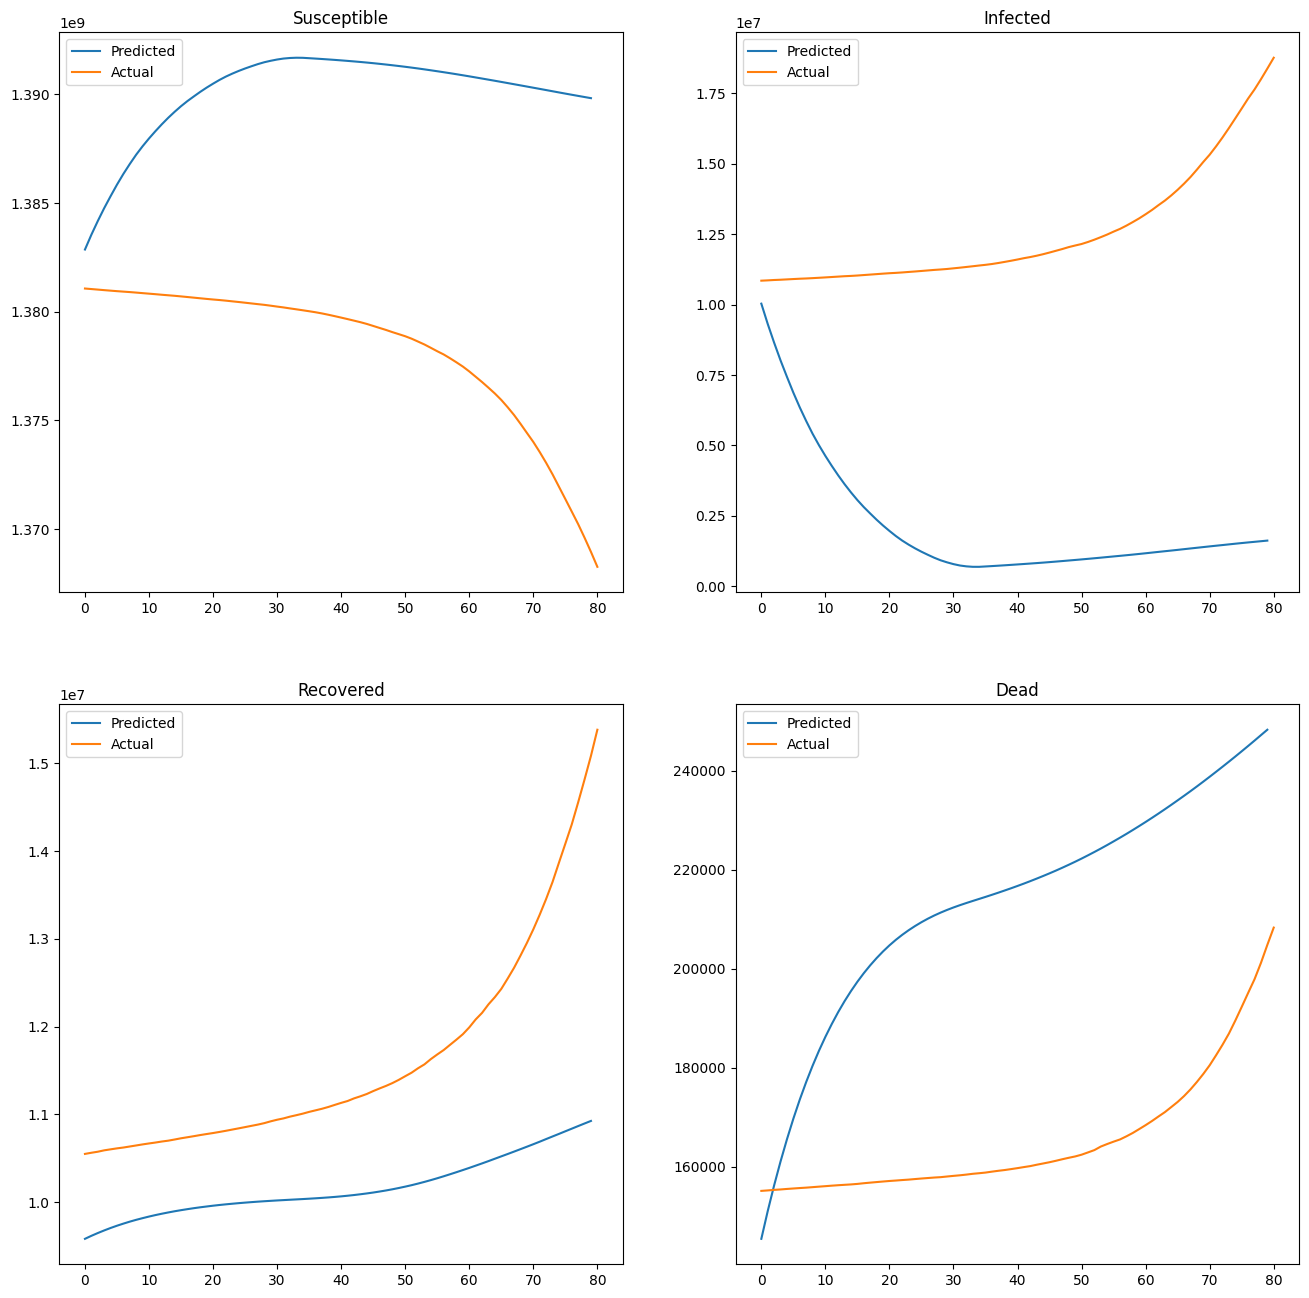

In [13]:
plot_epimodel(FFNNetEpimodel, test_data, 30)

Epoch 50/50, Loss: 0.0004
Epoch 50/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000


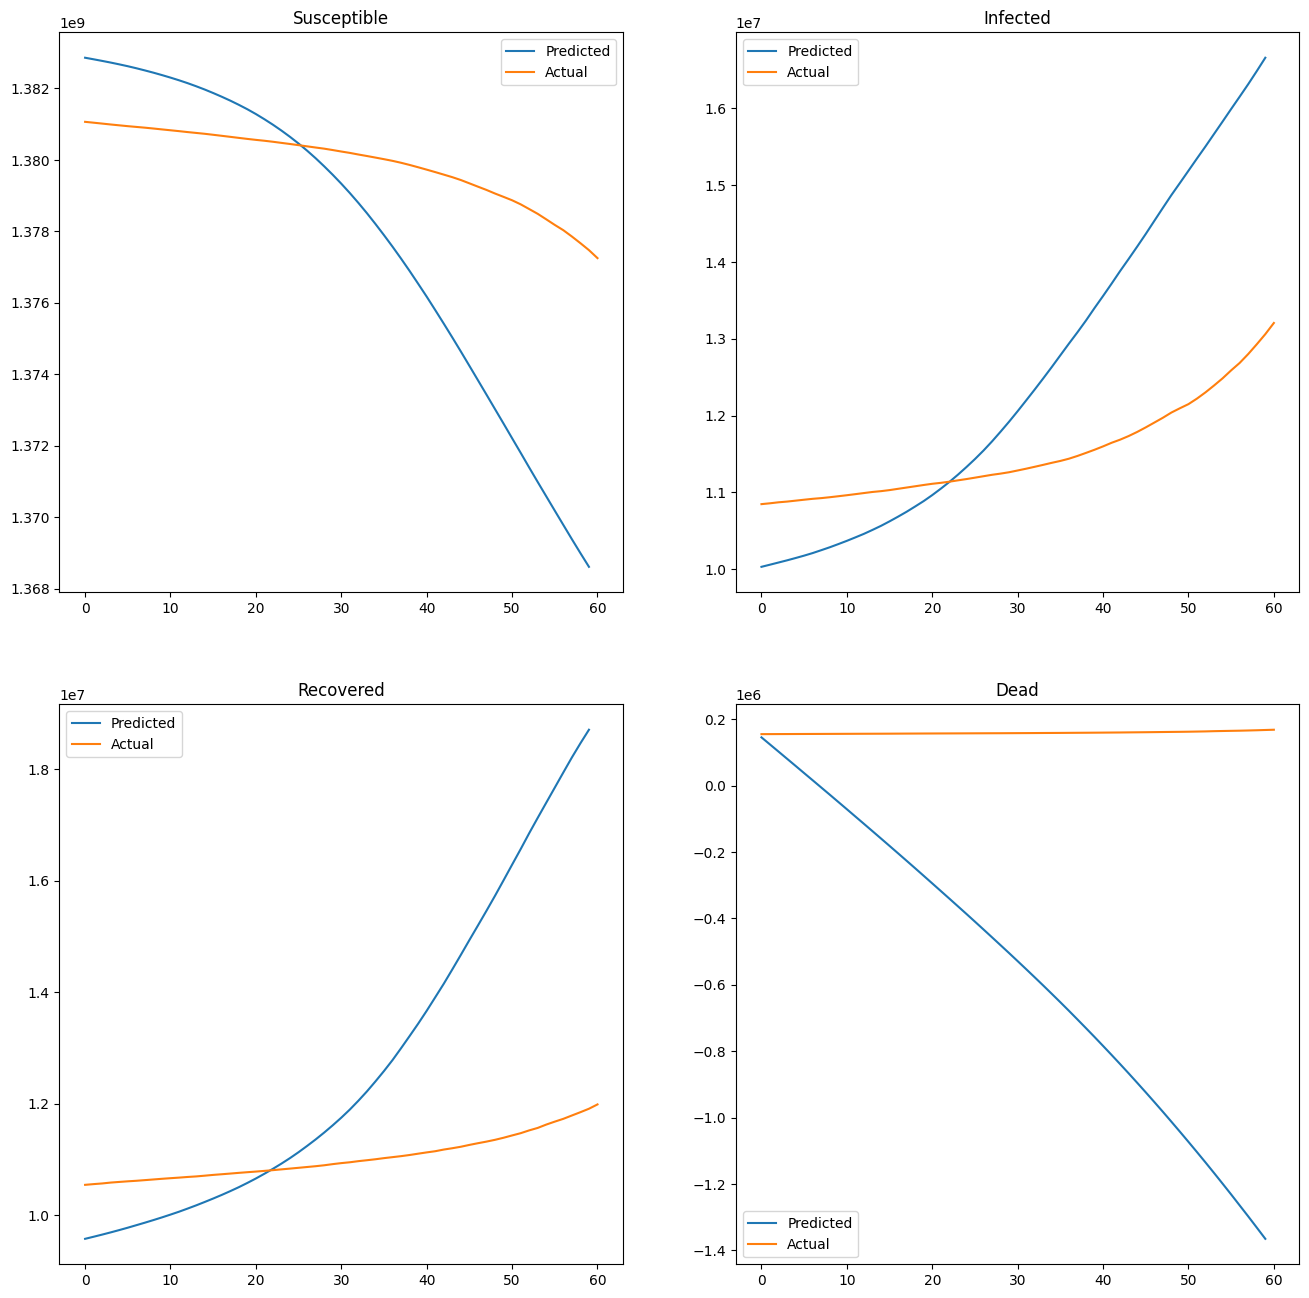

In [14]:
beta_preds = get_preds(FFNNet, "beta", 50)
gamma_preds = get_preds(FFNNet, "gamma", 50)
mu_preds = get_preds(FFNNet, "mu", 50)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

plot_epimodel(FFNNetEpimodel, test_data, 50)

In [20]:
class FFNNet_Fatter(nn.Module):

    def __init__(self, lookback):
        super(FFNNet_Fatter, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(lookback, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [21]:
class FFNNet_Longer(nn.Module):

    def __init__(self, lookback):
        super(FFNNet_Longer, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(lookback, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [22]:
class FFNNet_Fatter_n_Longer(nn.Module):

    def __init__(self, lookback):
        super(FFNNet_Fatter_n_Longer, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(lookback, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.net(x)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50/50, Loss: 0.0003
Epoch 50/50, Loss: 0.0001
Epoch 50/50, Loss: 0.0000


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


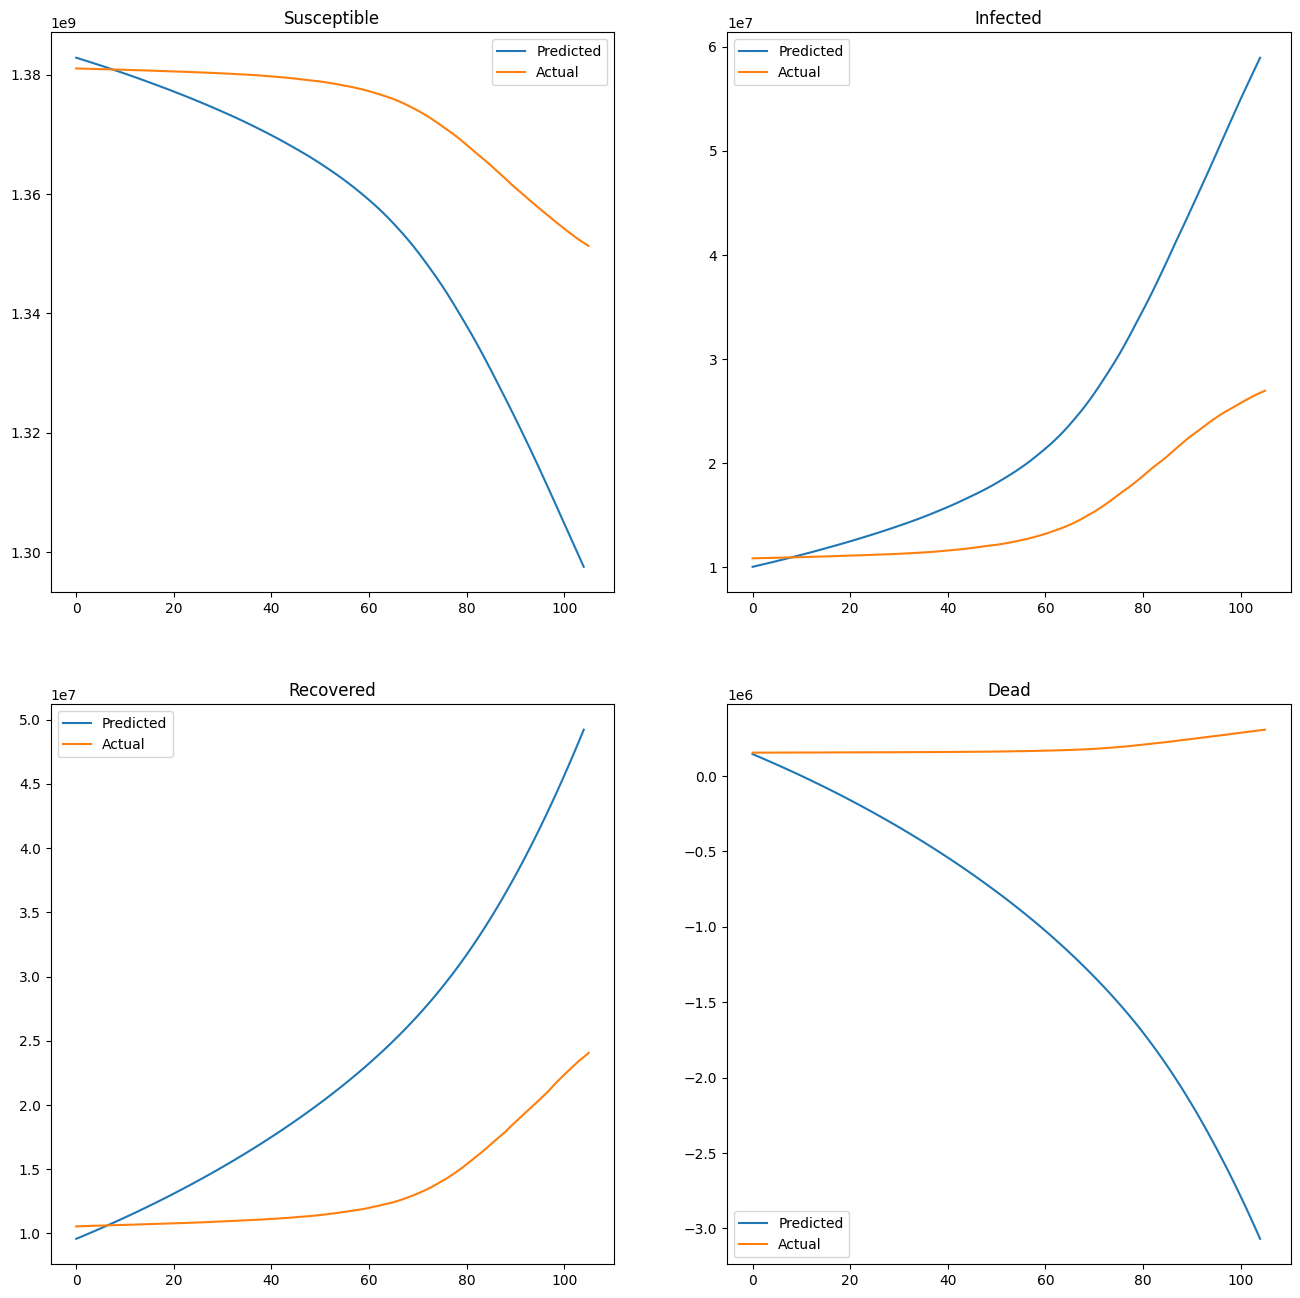

In [23]:
beta_preds = get_preds(FFNNet_Fatter, "beta", 5)
gamma_preds = get_preds(FFNNet_Fatter, "gamma", 5)
mu_preds = get_preds(FFNNet_Fatter, "mu", 5)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

plot_epimodel(FFNNetEpimodel, test_data, 5)

Epoch 50/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000


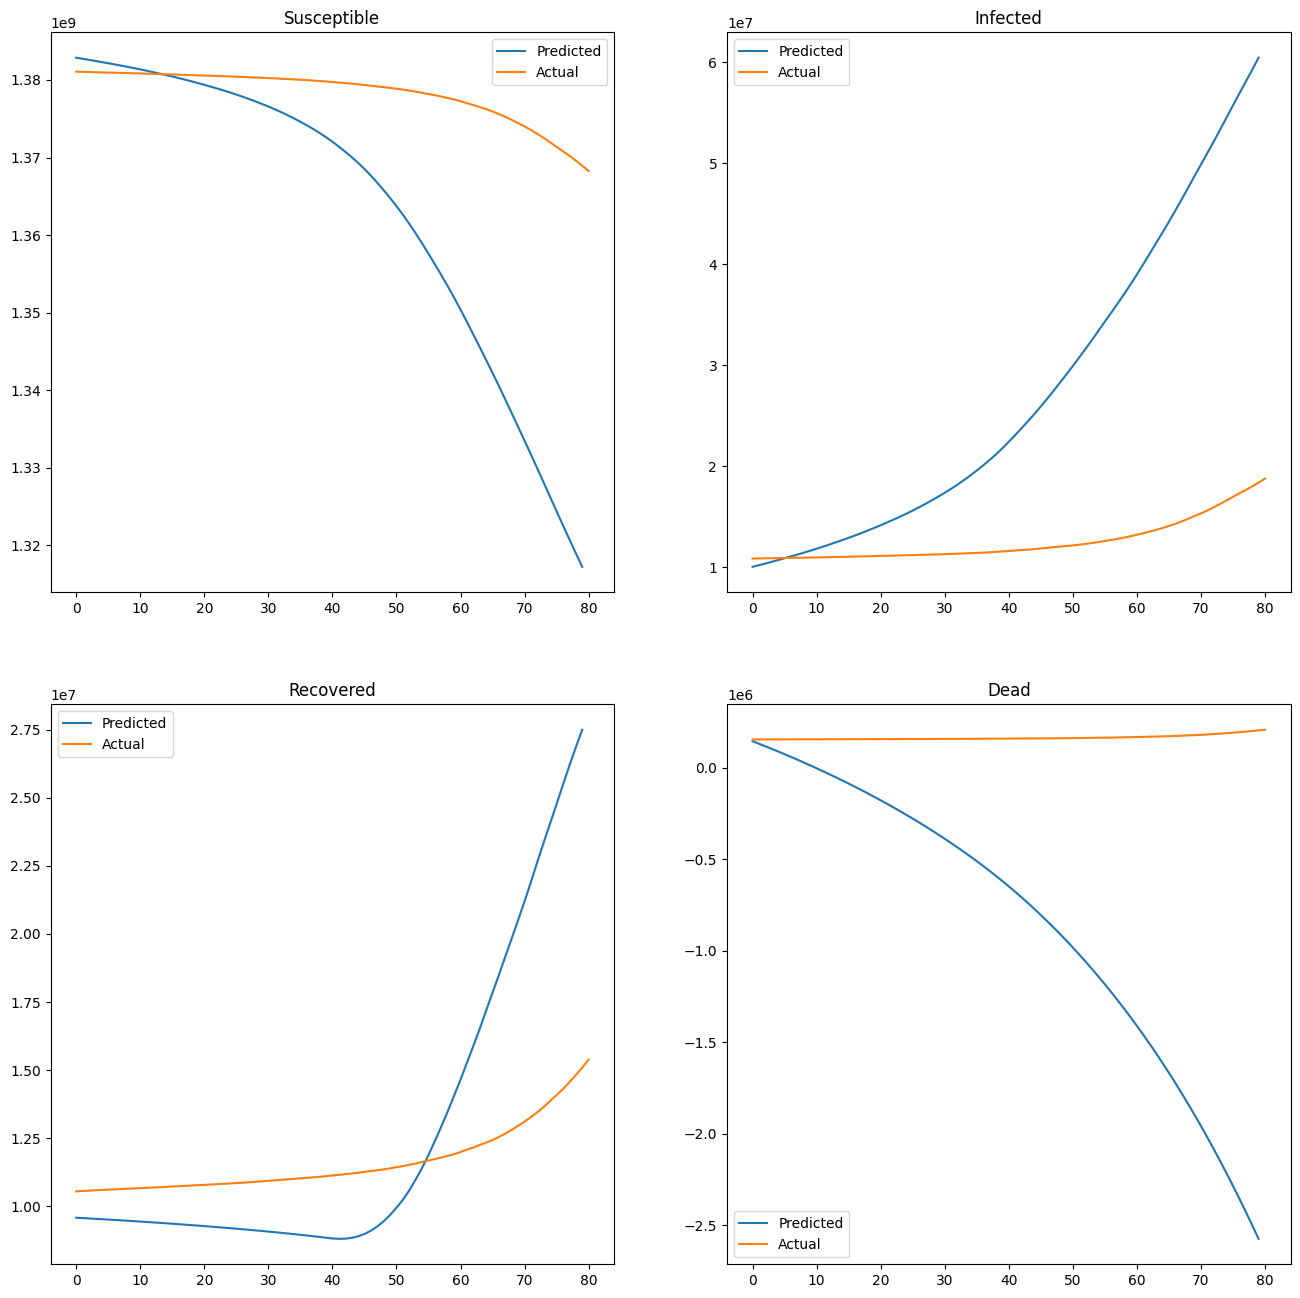

In [24]:
beta_preds = get_preds(FFNNet_Fatter, "beta", 30)
gamma_preds = get_preds(FFNNet_Fatter, "gamma", 30)
mu_preds = get_preds(FFNNet_Fatter, "mu", 30)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

plot_epimodel(FFNNetEpimodel, test_data, 30)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50/50, Loss: 0.0072
Epoch 50/50, Loss: 0.0008
Epoch 50/50, Loss: 0.0000


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


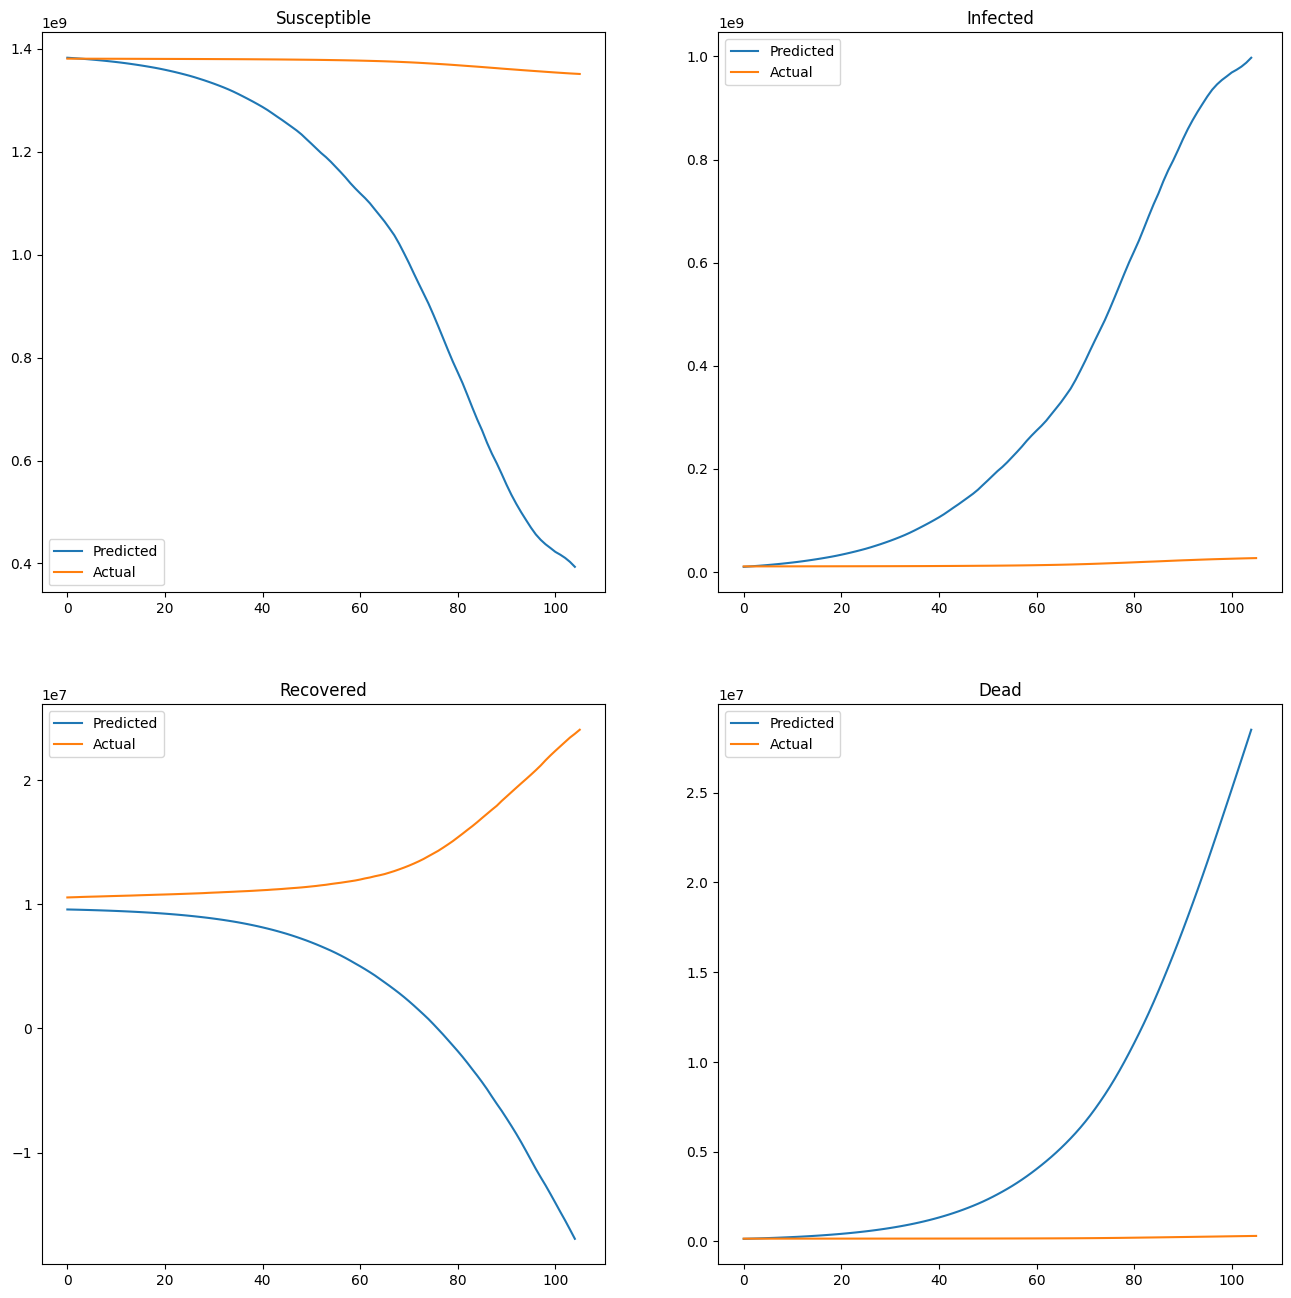

In [25]:
beta_preds = get_preds(FFNNet_Longer, "beta", 5)
gamma_preds = get_preds(FFNNet_Longer, "gamma", 5)
mu_preds = get_preds(FFNNet_Longer, "mu", 5)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

plot_epimodel(FFNNetEpimodel, test_data, 5)

Epoch 50/50, Loss: 0.0002
Epoch 50/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000


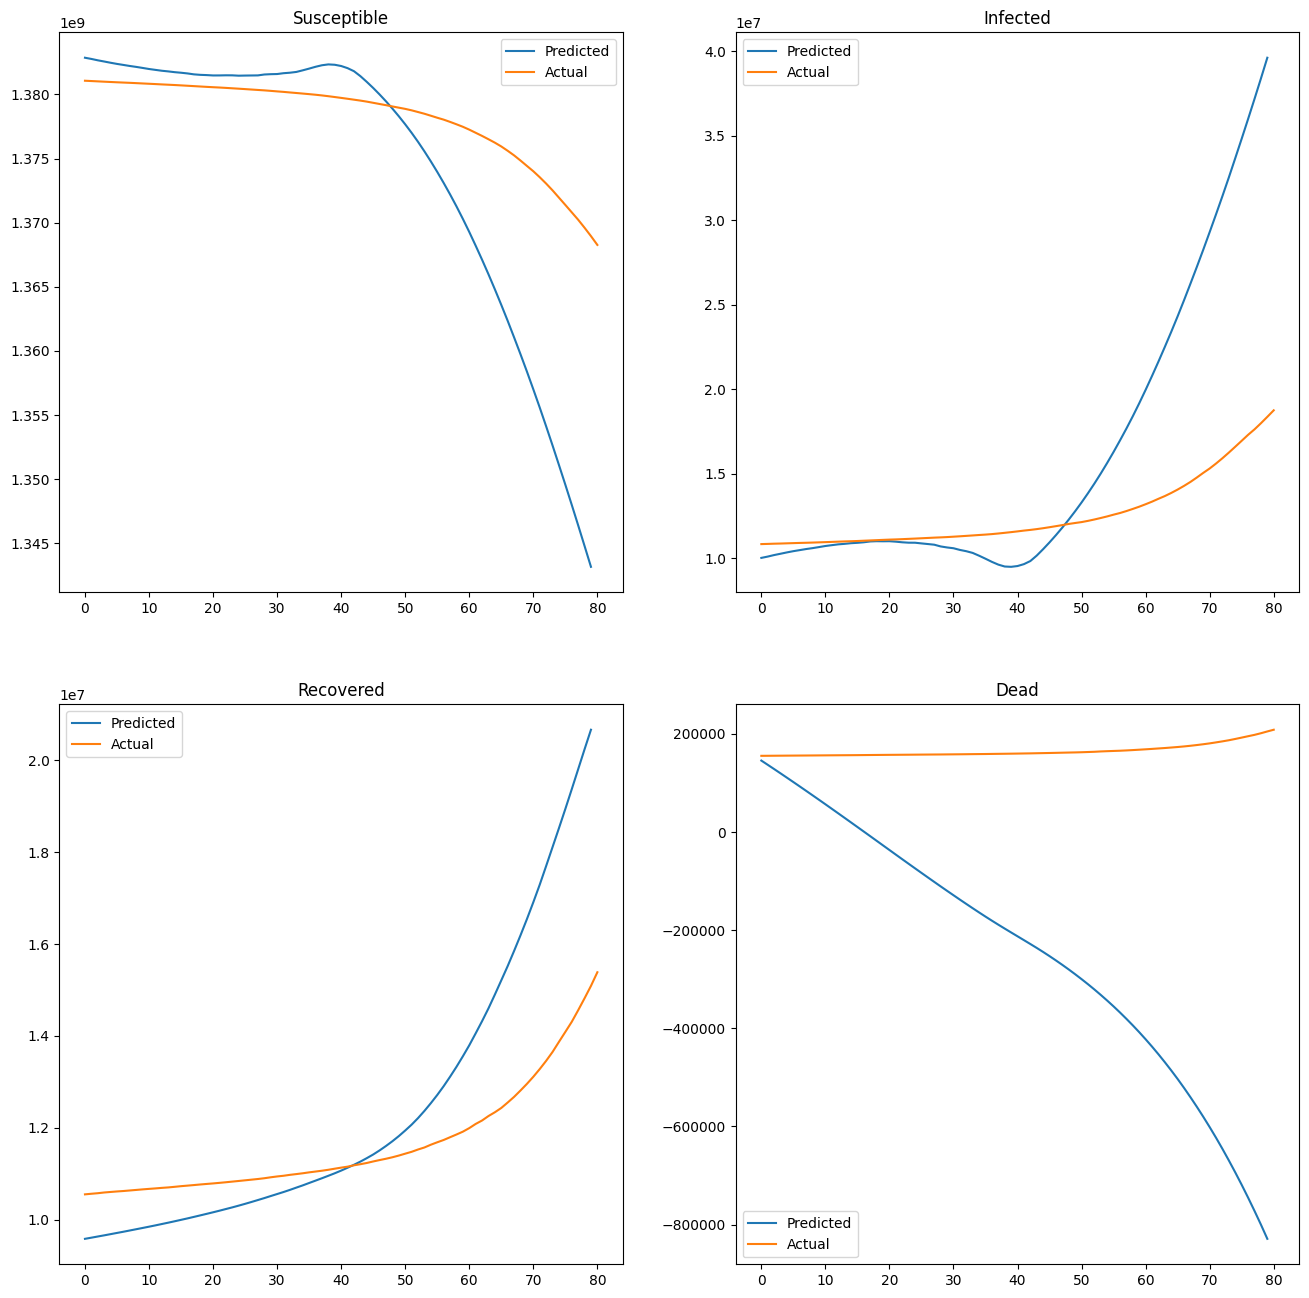

In [26]:
beta_preds = get_preds(FFNNet_Longer, "beta", 30)
gamma_preds = get_preds(FFNNet_Longer, "gamma", 30)
mu_preds = get_preds(FFNNet_Longer, "mu", 30)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

plot_epimodel(FFNNetEpimodel, test_data, 30)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50/50, Loss: 0.0039
Epoch 50/50, Loss: 0.0002
Epoch 50/50, Loss: 0.0000


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


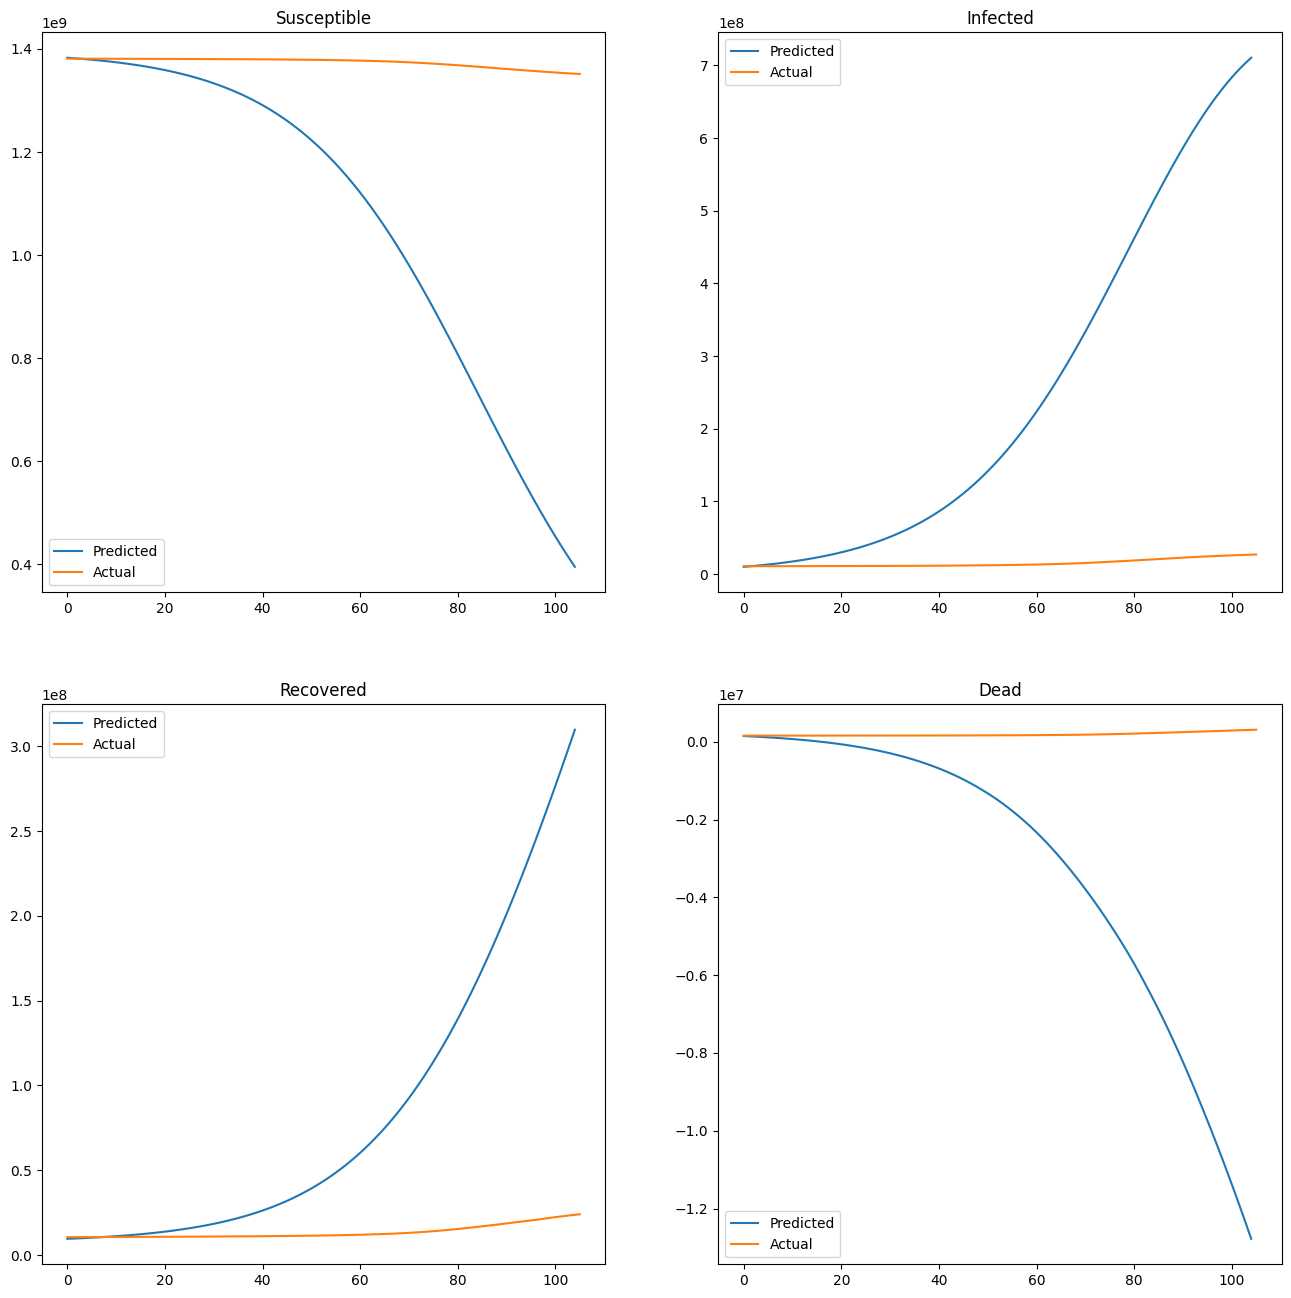

In [27]:
beta_preds = get_preds(FFNNet_Fatter_n_Longer, "beta", 5)
gamma_preds = get_preds(FFNNet_Fatter_n_Longer, "gamma", 5)
mu_preds = get_preds(FFNNet_Fatter_n_Longer, "mu", 5)

FFNNetEpimodel = EpiModel(beta_preds, gamma_preds, mu_preds, train_data.iloc[324][1:5].values)

plot_epimodel(FFNNetEpimodel, test_data, 5)